In [1]:
import pandas as pd
import numpy as np
from numpy import arange
import datetime as dt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, make_scorer

from cm import plot_confusion_matrix

import tensorflow as tf

In [2]:
#Checking GPU access

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
merge_geo_codes = pd.read_csv('data/merge_geo_codes.csv', low_memory = False)

# Custom TTS

In [4]:
#A function that simulates a train test split that keeps time sequences for trucks together, but still allows individual trucks
#to randomly be assigned to training and testing

def train_test_brake (df):
    df = df.sort_values('EventTimeStamp')
    t_len = df.shape[0]
    t_perc80 = int(t_len * 0.8)
    df80 = df.iloc[0 : t_perc80, :]
    df20 = df.iloc[t_perc80 : , :]
    return(df80, df20) 

In [5]:
dataframe_80_20 = merge_geo_codes.groupby('EquipmentID').apply(train_test_brake)

In [6]:
#Creates training dataset

df80 = pd.concat([x[0] for x in dataframe_80_20])

In [7]:
#Creates testing dataset

df20 = pd.concat([x[1] for x in dataframe_80_20])

In [8]:
bad_predictors = ['RecordID', 'EquipmentID', 'EventTimeStamp', 
                  'spn', 'fmi', 'ecuModel', 'activeTransitionCount',
                  'ecuSerialNumber', 'ecuSoftwareVersion', 
                  'eventDescription', 'Latitude', 'Longitude', 
                  'EquipmentID_y', 'EventTimeStamp_y', 'spnfmi_156931_y', 
                  'flagtime', 'deltatime', 'targettime']

In [9]:
predictors_train = df80.drop(bad_predictors, axis = 1)
predictors_test = df20.drop(bad_predictors, axis = 1)

In [10]:
# Predictors
X_train = predictors_train

X_test = predictors_test

# Target
y_train = df80.targettime

y_test = df20.targettime

# Lasso LogReg

In [62]:
#Smaller c values specify stronger regularization 
with tf.device('/gpu:0'):
    lasso = LogisticRegression(penalty = 'l1', 
                           C = 0.05, 
                           solver = 'saga', 
                           class_weight = {0: 1, 1: 50}, 
                           max_iter = 6000, 
                           warm_start = True    
                           ).fit(X_train, y_train)

D:\Anaconda3\envs\keras_env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [63]:
y_pred = lasso.predict(X_test)

In [64]:
accuracy_score(y_test, y_pred)

0.6752038442859699

In [65]:
lasso.coef_

array([[ 2.70409691e-06,  2.66938050e-05,  4.54900015e-05,
         0.00000000e+00, -8.72345355e-06,  1.69447742e-12,
        -7.09072040e-06, -4.28402066e-05,  8.47894657e-05,
        -4.91568594e-05, -1.05522965e-05, -1.29973262e-05,
        -2.04377448e-05, -3.31876449e-05, -1.09519591e-02,
        -7.43134487e-06,  0.00000000e+00, -2.54145809e-11,
        -3.26346525e-11, -2.25556104e-05, -7.57537592e-06,
         5.92577538e-05, -6.31326682e-06, -1.10191528e-04,
         1.47473649e-03,  0.00000000e+00, -2.76076359e-06,
         0.00000000e+00,  0.00000000e+00, -3.37263089e-05,
        -2.92879166e-11, -8.93158939e-06, -9.32820907e-05,
        -3.72999610e-05, -1.78906057e-05, -1.55591443e-04,
        -3.08418687e-03, -6.49018466e-05,  0.00000000e+00,
         6.40645504e-04, -1.97285495e-05, -1.19868505e-04,
         2.93149563e-06, -1.46748275e-04, -2.64590770e-05,
         0.00000000e+00, -3.76861431e-06, -5.77915903e-06,
         3.68606443e-05, -2.76993644e-05,  0.00000000e+0

In [66]:
lasso.intercept_

array([-0.00198416])

In [67]:
lasso.predict_proba(X_test)

array([[0.49977842, 0.50022158],
       [0.50031626, 0.49968374],
       [0.50036986, 0.49963014],
       ...,
       [0.37050596, 0.62949404],
       [0.36833388, 0.63166612],
       [0.3680582 , 0.6319418 ]])

In [68]:
confusion_matrix(y_test, y_pred)

array([[26020, 12484],
       [  223,   396]], dtype=int64)

D:\NSS\big_g_express-big_shot\cm.py:12: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s = labels[0], xy = (0.5, 2.05), va = 'bottom', ha = 'center', fontsize = fontsize)
D:\NSS\big_g_express-big_shot\cm.py:13: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s = labels[1], xy = (1.5, 2.05), va = 'bottom', ha = 'center', fontsize = fontsize)
D:\NSS\big_g_express-big_shot\cm.py:14: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s = labels[0], xy = (-0.05, 1.5), va = 'center', ha = 'right', fontsize = fontsize, rotation = 90)
D:\NSS\big_g_express-big_shot\cm.py:15: Mat

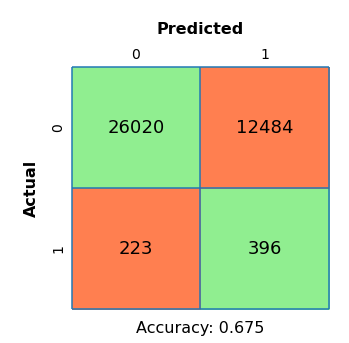

In [69]:
plot_confusion_matrix(y_test, y_pred, labels = ['0', '1'], metric = 'accuracy')

In [70]:
f1_score(y_test, y_pred, average = 'micro')

0.6752038442859699

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.68      0.80     38504
        True       0.03      0.64      0.06       619

    accuracy                           0.68     39123
   macro avg       0.51      0.66      0.43     39123
weighted avg       0.98      0.68      0.79     39123



# GridSearchCV on Lasso Penalty

In [15]:
model = LogisticRegression(penalty = 'l1', 
                       solver = 'saga',
                       max_iter = 7500, 
                       fit_intercept = True)

In [16]:
#grid = dict()
#grid['C'] = arange(0.05, 0.25, 0.05)

f1 = make_scorer(f1_score, pos_label = 1)

In [17]:
param_grid = {
    'C' : [0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40],
    'class_weight' : [{0:1, 1:1}, 
                      {0:1, 1:2},
                      {0:1, 1:5},
                      {0:1, 1:10},
                      {0:1, 1:25},
                      {0:1, 1:50}]
              }

In [18]:
search = GridSearchCV(estimator = model, 
                 param_grid = param_grid, 
                 scoring = f1, 
                 cv = 3)

In [ ]:
with tf.device('/gpu:0'):
    results = search.fit(X_train, y_train)

In [58]:
results

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=5000, penalty='l1',
                                          solver='saga'),
             param_grid={'C': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25])},
             scoring=<function f1_score at 0x000001B59A9C05E8>)

In [59]:
print(results.best_score_)

nan


In [60]:
print(results.best_params_)

{'C': 0.0}


In [ ]:
#TimeSeriesSplit